### BLIP

https://huggingface.co/Salesforce/blip-image-captioning-base

c:\Users\user\miniconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


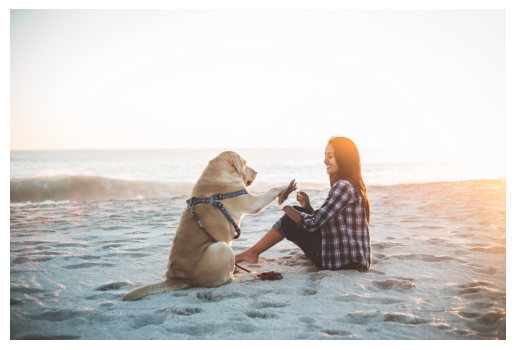

Execution Time: 0:00:00.795595

Generated Caption:
 a woman sitting on the beach with her dog


In [1]:
from datetime import datetime
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plt.imshow(raw_image)
plt.axis("off")
plt.show()

text = "a photography of"

# start = datetime.now()
# # conditional image captioning
# inputs = processor(raw_image, text, return_tensors="pt")

# out = model.generate(**inputs)
# print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
start = datetime.now()
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)

caption = processor.decode(out[0], skip_special_tokens=True)
# 실행 시간 출력
print("Execution Time:", datetime.now() - start)
print("\nGenerated Caption:\n", caption)

### LLAVA

https://huggingface.co/llava-hf/llava-onevision-qwen2-0.5b-ov-hf
https://huggingface.co/llava-hf/llava-1.5-7b-hf

c:\Users\user\miniconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


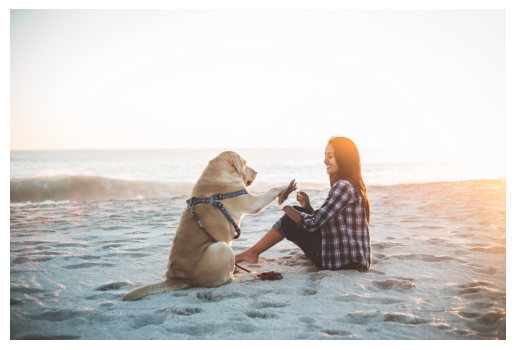

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Execution Time: 0:00:06.632770

Generated Caption:
  
Describe the image in detail.assistant
The image captures a serene moment on a beach at sunset. A woman and a golden retriever are the main subjects of the photo. The woman, dressed in a plaid shirt, is sitting on the sandy beach, her feet sinking slightly into the soft grains. She is holding out her hand, offering a treat to the golden retriever. The dog, wearing a blue harness, is sitting obediently, its attention focused on the woman's hand.

The background of the image is a beautiful blend


In [1]:
from datetime import datetime
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig


model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"

# BitsAndBytes 설정 (4비트 양자화)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4비트 양자화 적용
    bnb_4bit_compute_dtype=torch.float16,  # 계산에 사용할 데이터 타입
    bnb_4bit_use_double_quant=True,  # 이중 양자화 사용
    bnb_4bit_quant_type="nf4"  # NormalFloat4 (nf4) 적용
)

model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16,
    quantization_config=bnb_config,  # 양자화 설정 적용
    # load_in_4bit=True,
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plt.imshow(raw_image)
plt.axis("off")
plt.show()

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "Describe the image in detail."},
          {"type": "image"},
        ],
    },
]

start = datetime.now()
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.float16)

# 모델 추론
with torch.no_grad():
    # output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    output = model.generate(**inputs, max_new_tokens=100, do_sample=False)

# 결과 디코딩
caption = processor.decode(output[0][2:], skip_special_tokens=True)

# 실행 시간 출력
print("Execution Time:", datetime.now() - start)
print("\nGenerated Caption:\n", caption)

In [3]:
from datetime import datetime
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

# 모델 및 프로세서 로드
model_id = "llava-hf/llava-1.5-7b-hf"

# BitsAndBytes 설정 (4비트 양자화)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4비트 양자화 적용
    bnb_4bit_compute_dtype=torch.float16,  # 계산에 사용할 데이터 타입
    bnb_4bit_use_double_quant=True,  # 이중 양자화 사용
    bnb_4bit_quant_type="nf4"  # NormalFloat4 (nf4) 적용
)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16,
    quantization_config=bnb_config,  # 양자화 설정 적용
    # load_in_4bit=True,
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

# 이미지 로드 및 RGB 변환
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# 대화 프롬프트 설정
conversation = [
    {
      "role": "user",
      "content": [
          {"type": "text", "text": "Describe the image in detail."},
          {"type": "image"},
        ],
    },
]

# 프롬프트 변환
start = datetime.now()
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

# 모델 입력 처리
inputs = processor(images=raw_image, text=prompt, return_tensors="pt").to("cuda", torch.float16)

# 모델 추론
with torch.no_grad():
    output_ids = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    # output_ids = model.generate(**inputs, max_new_tokens=100, do_sample=False)

# 결과 디코딩
caption = processor.decode(output_ids[0][2:], skip_special_tokens=True)

# 실행 시간 출력
print("Execution Time:", datetime.now() - start)
print("\nGenerated Caption:\n", caption)


Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


Execution Time: 0:00:08.123019

Generated Caption:
 ER:  
Describe the image in detail. ASSISTANT: The image features a woman sitting on a beach, petting a large, light-colored dog. The dog is wearing a collar, and the woman appears to be enjoying her time with the dog. The scene is set against a beautiful beach backdrop, with the ocean visible in the background.
